In [3]:
# Colab package installations
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

     |████████████████████████████████| 484.0MB 6.3MB/s 
ERROR: fastai 1.0.52 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
     |████████████████████████████████| 235kB 32.6MB/s 
     |████████████████████████████████| 61kB 26.4MB/s 
     |████████████████████████████████| 676.9MB 21kB/s 
  Stored in directory: /root/.cache/pip/wheels/7f/2f/21/9f840307c05be374f101b0e4aee2db0596437fe2ade0334c2f
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum
  Found existing installation: torch 0.4.0
    Uninstalling torch-0.4.0:
      Successfully uninstalled torch-0.4.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.distributions.constraints as constraints

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
import seaborn

import pyro
from pyro.distributions import Normal, Categorical,Beta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import normalize

%matplotlib inline

In [0]:
batch_size = 100
input_size = 3*32*32
hidden_size = 512
output_size = 10

log_softmax = nn.LogSoftmax(dim=1).to(device)
softplus = nn.Softplus().to(device)

In [0]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.l2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h = self.relu(self.l1(x.view((-1, input_size))))
        yhat = self.l2(h)
        return yhat

mlp = MLP().to(device)


# Model

def normal(*shape):
    loc = torch.zeros(*shape).to(device)
    scale = torch.ones(*shape).to(device)
    return Normal(loc, scale)

# observations ⟺ pyro.sample with the obs argument
def model(imgs, lbls):
    priors = {
        'l1.weight': normal(hidden_size, input_size), 'l1.bias': normal(hidden_size),
        'l2.weight': normal(output_size, hidden_size), 'l2.bias': normal(output_size)}
    lifted_module = pyro.random_module("mlp", mlp, priors)
    lifted_reg_model = lifted_module()
    lhat = log_softmax(lifted_reg_model(imgs))
    pyro.sample("obs", Categorical(logits=lhat), obs=lbls)


# Inference Guide

def vnormal(name, *shape):
    loc = pyro.param(name+"m", torch.randn(*shape, requires_grad=True, device=device))
    scale = pyro.param(name+"s", torch.randn(*shape, requires_grad=True, device=device))
    return Normal(loc, softplus(scale))

# approximation to the posterior
def guide(imgs, lbls):
    dists = {
        'l1.weight': vnormal("W1", hidden_size, input_size), 'l1.bias': vnormal("b1", hidden_size),
        'l2.weight': vnormal("W2", output_size, hidden_size), 'l2.bias':vnormal("b2", output_size)}
    lifted_module = pyro.random_module("mlp", mlp, dists)
    return lifted_module()

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170205184/170498071 [02:23<00:00, 2127415.72it/s]

Files already downloaded and verified


In [8]:
num_epochs = 5
print("num_epochs ", num_epochs)

## Inference

inference = SVI(model, guide, Adam({"lr": 0.005}), loss=Trace_ELBO())

print('Inference')
print(len(train_loader))

for epoch in range(num_epochs):
    
    for j, (imgs, lbls) in tqdm(enumerate(train_loader, 0)):
        loss = inference.step(imgs.to(device), lbls.to(device))
        
    print("Epoch ", epoch, "Loss", loss)

num_epochs  5
Inference
500


170500096it [02:40, 2127415.72it/s]                               


Epoch  0 Loss 663076.4797515869


Exception ignored in: <bound method tqdm.__del__ of 170500096it [02:41, 2127415.72it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread



Epoch  1 Loss 305095.60258865356



Epoch  2 Loss 139532.81350326538



Epoch  3 Loss 94441.24525165558



Epoch  4 Loss 57449.27350616455


In [9]:
# Network is forced to predict

num_samples = 10
# (num_samples) models with potentially different priors.
# Take the average to infer


def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    yhats = torch.stack(yhats)
    mean = torch.mean(yhats,0)
#     mean = torch.median(yhats)
    return torch.argmax(mean)



print('Prediction')
print("Num epochs used in training ", num_epochs)
correct = 0
total = 0
print("# iterations required ",len(test_loader))
for j, data in tqdm(enumerate(test_loader)):
  
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    predicted = predict(images)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

        
print("accuracy: %d %%" % (100 * correct / total))


Prediction
Num epochs used in training  5
# iterations required  10000



accuracy: 33 %


In [10]:
correct, total

(3301, 10000)

In [0]:

classes_dict = {0:'plane', 1:'automobile', 2:'bird', 3:'cat',
           4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
   
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 30
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1, input_size)).data, 1).detach() for model in sampled_models]
    return np.asarray(yhats)


In [0]:
correctPerLabel = [0]*10
rejected_idx = []
# rejected_probs = torch.zeros([10])


def test_batch(images, labels, img_index, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0
    

    for i in range(len(labels)):
    
        all_imgs_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False

            histo_exp = []
        
            for z in range(y.shape[0]):

                histo_exp.append(torch.exp(y[z][i][j]))
              
            prob = torch.median(torch.tensor(histo_exp))

        
            if(prob>0.2):
                highlight = True 

        
            all_imgs_prob.append(prob)
            
        
            if(highlight):
                highted_something = True
                
                
        predicted = np.argmax(all_imgs_prob)
    
        if(highted_something):
            predicted_for_images+=1
            truth = labels[i].item()
            if(truth==predicted):
                correct_predictions +=1.0
                classIdx = classes.index(classes[truth])
                correctPerLabel[classIdx] += 1
        else:
            rejected_idx.append(img_index)
#             for k, pr in enumerate(all_imgs_prob):
#               rejected_probs[k] += pr
                
    return len(labels), correct_predictions, predicted_for_images, correctPerLabel, all_imgs_prob
    

In [15]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
print(len(test_loader))
for j, data in tqdm(enumerate(test_loader, 0)):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    total_minibatch, correct_minibatch, predictions_minibatch, correctPerLabel, all_imgs_prob = test_batch(images,
                                                                                            labels,
                                                                                            j,
                                                                                            plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))
print(classes_dict)
print("correct per label", correctPerLabel)



Prediction when network can refuse
10000



Total images:  10000
Skipped:  8664
Accuracy when made predictions: 63 %
{0: 'plane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
correct per label [365, 154, 7, 18, 36, 33, 11, 88, 74, 56]


In [16]:
correct/ total_predicted_for

0.6302395209580839

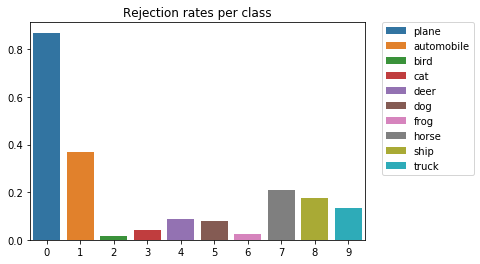

In [18]:
mis_ratio = normalize(np.asarray(correctPerLabel, dtype=np.float). reshape(1,-1))
mis_ratio = mis_ratio.squeeze(0)

classes = ('plane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
seaborn.barplot(x=[0,1,2,3,4,5,6,7,8,9], y=mis_ratio, hue=classes, dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Rejection rates per class")
plt.show()

In [0]:
rejected_samples = np.random.choice(rejected_idx, size=10)
classified = [x for x in range(len(testset)) if x not in rejected_samples]
classified_samples = np.random.choice(classified, 10)

In [20]:
testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)
classes = ['plane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


truck


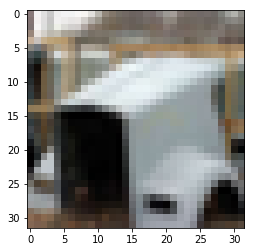

ship


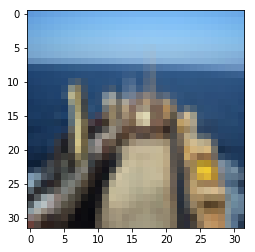

automobile


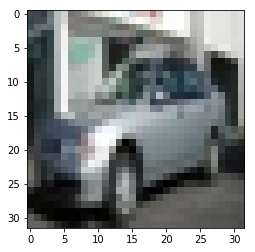

bird


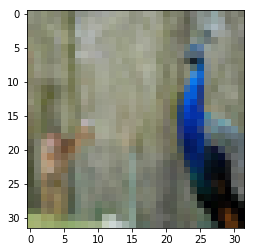

ship


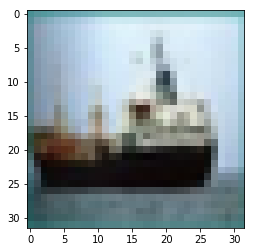

automobile


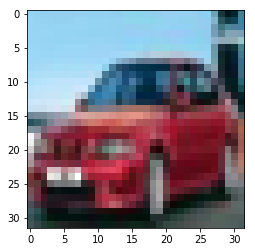

dog


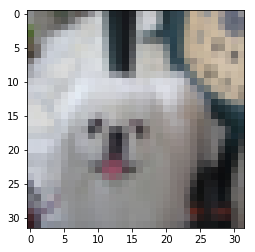

frog


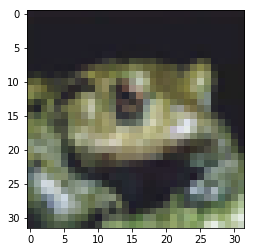

cat


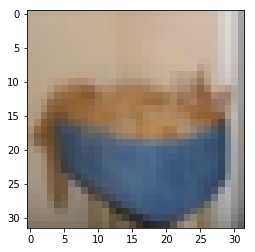

bird


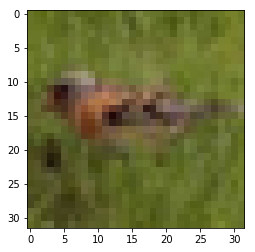

In [21]:

# rejected
for i in rejected_samples:
  print(classes[testset2[i][1]])
  plt.imshow(testset2[i][0])
  plt.show()

deer


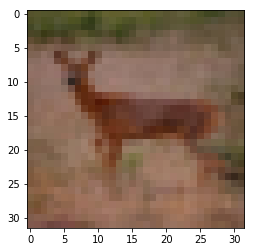

truck


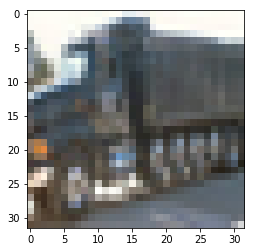

plane


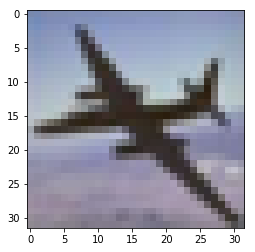

truck


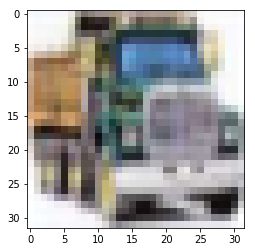

ship


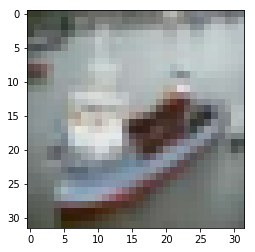

deer


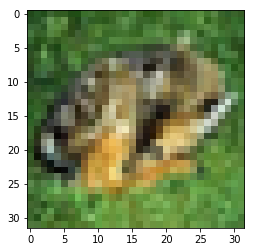

dog


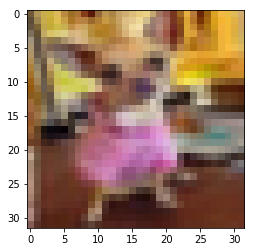

dog


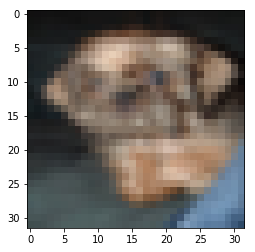

plane


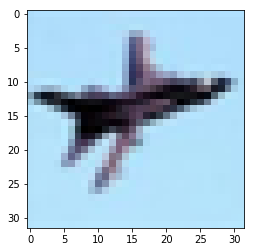

ship


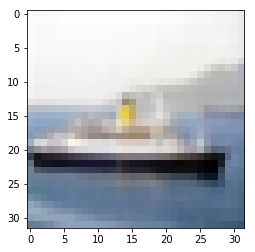

In [22]:
# classified

for i in classified_samples:
  print(classes[testset2[i][1]])
  plt.imshow(testset2[i][0])
  plt.show()